# JP Morgan's Quantitative Research Simulation: Overview

### Task 1: Natural Gas Price Forecasting
- **Objective**: Develop and apply a curve-fitting methodology to forecast natural gas prices using historical data.
- **Key Output**: Fitted price curve and future price predictions.

### Task 2: Natural Gas Storage Contract Valuation
- **Objective**: Simulate and value a natural gas storage contract by accounting for injection/withdrawal operations, associated costs (purchase, fees, storage), and revenues (sales).
- **Key Output**: Calculated net profit (or loss) of the storage contract, with a conclusion on its profitability.

### Task 3: Credit Risk Modeling & Expected Loss Calculation
- **Objective**: Build a Logistic Regression model to predict the Probability of Default (PD) for loan applicants, and implement a function to calculate Expected Loss.
- **Key Output**: A trained PD model, its evaluation metrics (misclassification rate, ROC AUC), and an `Expected Loss` calculator function for individual loans.

### Task 4: FICO Score Quantization & Rating System Development
- **Objective**: Quantize continuous FICO credit scores into discrete risk buckets using two methodologies: K-Means (minimizing MSE) and Dynamic Programming (maximizing Log-Likelihood).
- **Key Output**: Defined FICO score boundaries for credit ratings, comparative analysis of the methods, and a recommendation for credit risk assessment.

In [39]:
# Importing Necessary Libraries:

# Core Data & Math
import pandas as pd
import numpy as np
import math
from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning & Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Scientific Computing
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

# Utility
import joblib  # For saving & loading models

# Natural Gas Price Analysis:

## Task 1 (Part A): Time Series Analysis and Forecasting

### Dataset Overview
- **Source**: Monthly natural gas prices (provided as part of the job simulation).
- **Data Period**: Ranges from October 2020 to September 2024.
- **Format**: CSV file with columns:
  - `Dates`: End-of-month timestamps (MM/DD/YY)
  - `Prices`: Natural gas prices in USD/MMBtu

### Key Analysis Components

#### 1. Data Preparation
- Converted `Dates` column to datetime objects.
- Set `Dates` as DataFrame index for efficient time series operations.
- Created `Date_Numeric` column to represent days since the earliest record, for numerical modeling and interpolation.

#### 2. Price Estimation Framework
**Objective**: To develop a robust framework for investigating and analyzing historical natural gas price data, enabling accurate price estimation for both historical (interpolation) and future (extrapolation) dates.

### Interpolation (Historical Dates)
- **Methodology**: Utilized cubic spline interpolation (`scipy.interpolate.interp1d` with `kind='cubic'`) for any date *within* the observed historical range.
- **Benefit**: Provides a smooth and continuous price estimate, accurately filling in data gaps between observed monthly prices.

### Extrapolation (Future Dates)
- **Methodology**: Employed a hybrid model for forecasting prices up to one year into the future, combining:
    - **Linear Trend Component**: Calculated from the price change over the last 12 months of available data.
    - **Seasonal Adjustment**: Applied based on historical monthly average prices to capture recurring annual patterns.
- **Forecast Horizon & Warning System**: Implemented a strict 1-year extrapolation limit from the last available data point, with a warning system for estimates beyond this horizon due to increasing uncertainty.
- **Error Handling**: Includes checks for dates before the earliest historical data and handles cases with insufficient data for trend calculation.

#### 3. Visualization
- **Comprehensive Price Plot**: Generated a detailed plot displaying:
    - Actual historical monthly prices.
    - Continuously estimated prices (via interpolation for historical dates).
    - Projected future prices (via extrapolation for future dates).
    - A clear demarcation line indicating the end of actual data and the start of the forecast horizon.

#### 4. Model Validation
- **Backtesting Strategy**: Assessed the model's predictive power by:
    - Splitting the dataset into a training set (e.g., up to September 2023) and a test set (the subsequent 12 months).
    - Training the price estimator function exclusively on the training data.
    - Generating predictions for the held-out test period.
- **Performance Metrics**: Quantified the accuracy of the extrapolated forecasts using:
    - **Mean Absolute Error (MAE)**: Average absolute difference between actual and predicted prices.
    - **Root Mean Squared Error (RMSE)**: Square root of the average of the squared errors, penalizing larger deviations more significantly.
- Backtesting results and metrics are printed to indicate the model's forecasting reliability.

Data to work with:
       Dates  Prices
0 2020-10-31    10.1
1 2020-11-30    10.3
2 2020-12-31    11.0
3 2021-01-31    10.9
4 2021-02-28    10.9

Original Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Dates   48 non-null     datetime64[ns]
 1   Prices  48 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 900.0 bytes


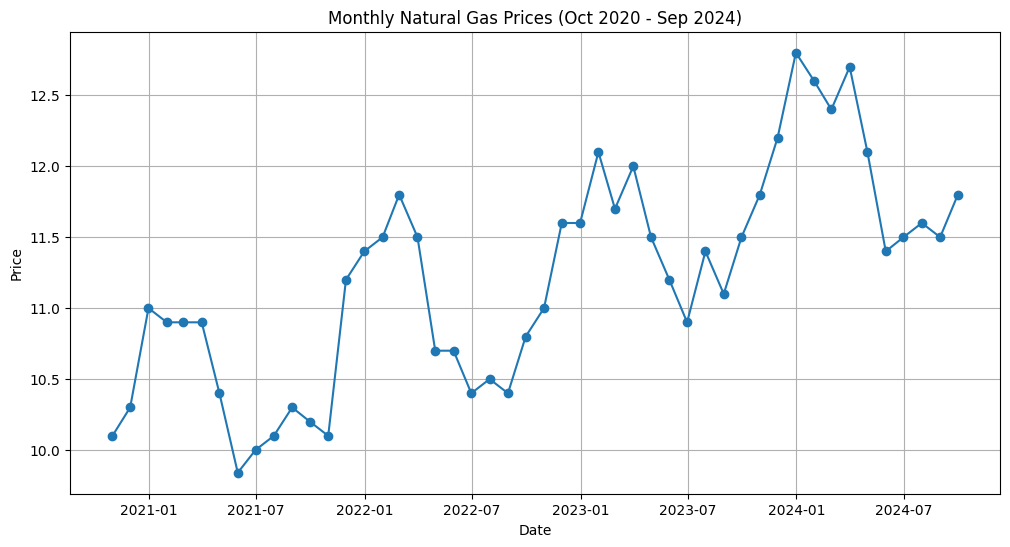

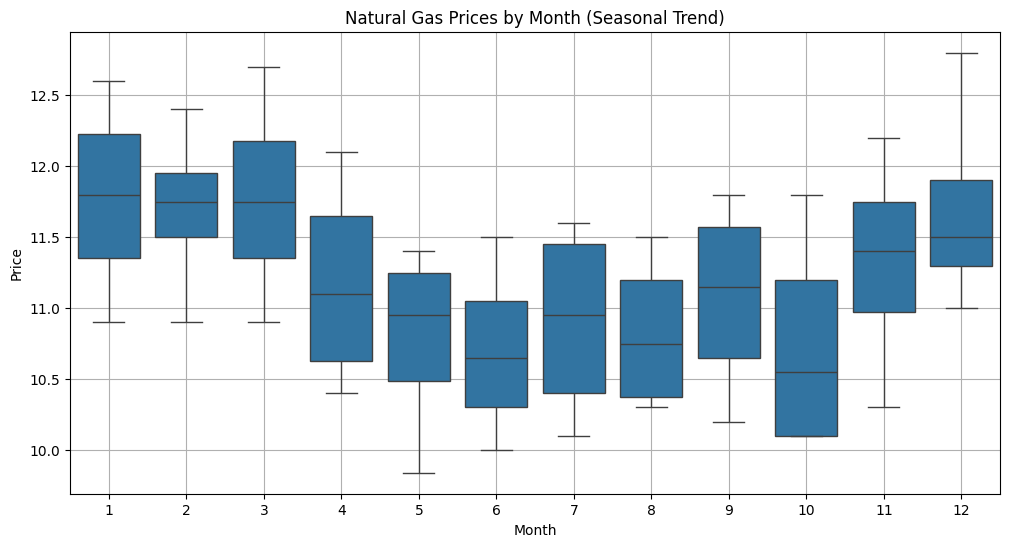

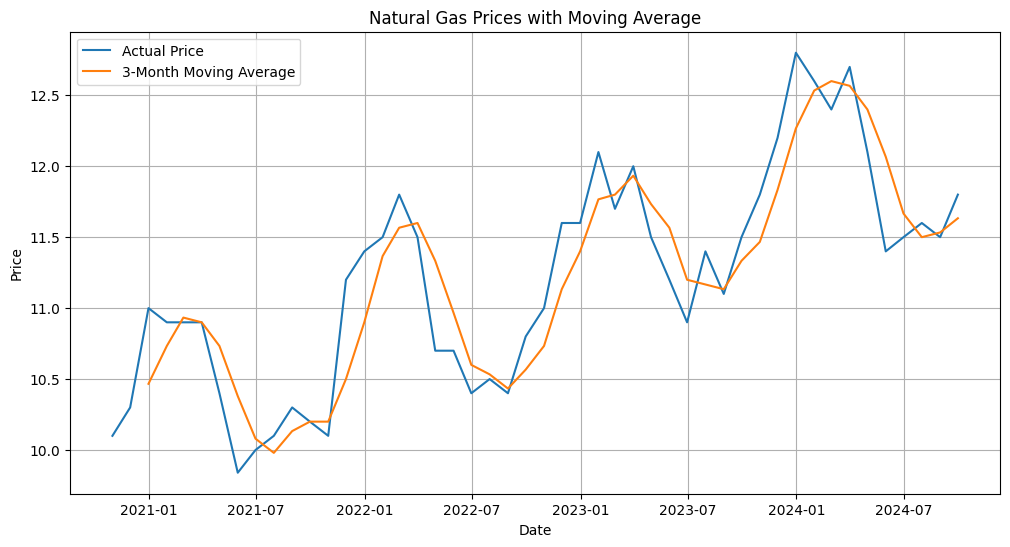

In [40]:
df = pd.read_csv('Nat_Gas.csv')

df['Dates'] = pd.to_datetime(df['Dates'], format='%m/%d/%y')

prices = df['Prices'].values
dates = df['Dates'].values

print("Data to work with:")
print(df.head())
print("\nOriginal Data Info:")
df.info()

# Use df['Dates'] for x-axis
plt.figure(figsize=(12, 6))
plt.plot(df['Dates'], df['Prices'], marker='o', linestyle='-')
plt.title('Monthly Natural Gas Prices (Oct 2020 - Sep 2024)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

df['Month'] = df['Dates'].dt.month
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='Prices', data=df)
plt.title('Natural Gas Prices by Month (Seasonal Trend)')
plt.xlabel('Month')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# 3 months rolling average
df['Price_MA_3M'] = df['Prices'].rolling(window=3).mean()
plt.figure(figsize=(12, 6))
plt.plot(df['Dates'], df['Prices'], label='Actual Price')
plt.plot(df['Dates'], df['Price_MA_3M'], label='3-Month Moving Average')
plt.title('Natural Gas Prices with Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


--- Price Estimation Examples ---
Estimated price for 2022-03-15: $11.77
Estimated price for 2025-06-15: $11.29
Error: Target date 2020-01-01 is before the earliest available data 2020-10-31.


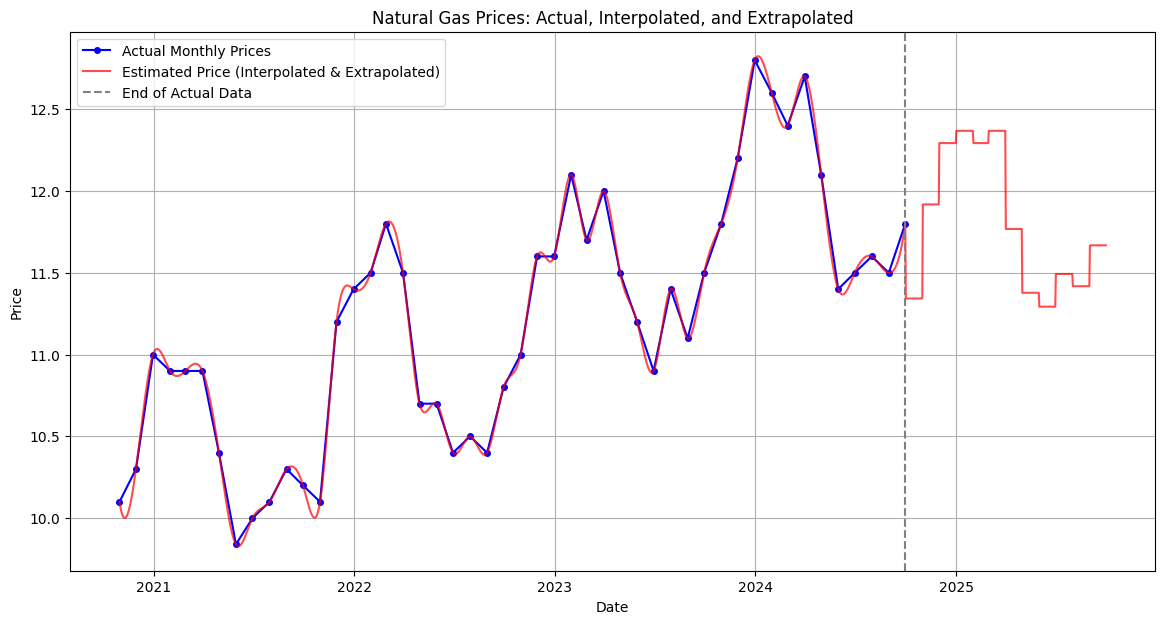


--- Overall Accuracy Metric (Forecasting Backtest) ---
Backtesting Period: 2023-10-31 to 2024-09-30
Number of test points: 12
Mean Absolute Error (MAE): $0.32
Root Mean Squared Error (RMSE): $0.40


In [41]:
df = df.set_index('Dates') # Set the 'Dates' column as the DataFrame's index

# --- Interpolation Setup ---
df['Date_Numeric'] = (df.index - df.index.min()).days

f_interp = interp1d(df['Date_Numeric'], df['Prices'], kind='cubic', fill_value="extrapolate")

# --- Extrapolation Setup ---
monthly_avg_prices = df.groupby(df.index.month)['Prices'].mean()

last_12_months = df.tail(12)
if len(last_12_months) > 1:
    monthly_trend = (last_12_months['Prices'].iloc[-1] - last_12_months['Prices'].iloc[0]) / (len(last_12_months) - 1)
else:
    monthly_trend = 0

def estimate_natural_gas_price(target_date_str, df_original, f_interpolator, monthly_avg_prices, monthly_trend):

    target_date = pd.to_datetime(target_date_str)
    min_date = df_original.index.min()
    max_date = df_original.index.max()

    # If the date is within the existing range (interpolation)
    if min_date <= target_date <= max_date:
        target_date_numeric = (target_date - min_date).days
        estimated_price = f_interpolator(target_date_numeric).item()
        return estimated_price
    # If the date is in the future (extrapolation)
    elif target_date > max_date:
        extrapolation_end_date = max_date + pd.DateOffset(years=1)
        if target_date > extrapolation_end_date:
            print(f"Warning: Target date {target_date.strftime('%Y-%m-%d')} is beyond the 1-year extrapolation limit of {extrapolation_end_date.strftime('%Y-%m-%d')}.")
            return None

        months_diff = (target_date.to_period('M') - max_date.to_period('M')).n

        base_price = df_original.loc[max_date]['Prices']
        trend_component = monthly_trend * months_diff

        target_month = target_date.month
        overall_historical_avg = df_original['Prices'].mean()
        # Use .loc with the month number as the index for monthly_avg_prices
        avg_price_for_target_month = monthly_avg_prices.loc[target_month]
        seasonal_deviation = avg_price_for_target_month - overall_historical_avg

        estimated_price = base_price + trend_component + seasonal_deviation
        estimated_price = max(0.01, estimated_price)

        return estimated_price
    else:
        print(f"Error: Target date {target_date.strftime('%Y-%m-%d')} is before the earliest available data {min_date.strftime('%Y-%m-%d')}.")
        return None

def create_price_estimator(df):

    df['Date_Numeric'] = (df.index - df.index.min()).days

    f_interp = interp1d(df['Date_Numeric'], df['Prices'], kind='cubic', fill_value="extrapolate")

    monthly_avg_prices = df.groupby(df.index.month)['Prices'].mean()

    # Calculate monthly trend using last 12 months
    last_12_months = df.tail(12)
    if len(last_12_months) > 1:
        monthly_trend = (last_12_months['Prices'].iloc[-1] - last_12_months['Prices'].iloc[0]) / (len(last_12_months) - 1)
    else:
        monthly_trend = 0

    return f_interp, monthly_avg_prices, monthly_trend

print("\n--- Price Estimation Examples ---")

date_to_estimate_interp = '2022-03-15'
price_interp = estimate_natural_gas_price(date_to_estimate_interp, df, f_interp, monthly_avg_prices, monthly_trend)

if price_interp is not None:
    print(f"Estimated price for {date_to_estimate_interp}: ${price_interp:.2f}")

date_to_estimate_extrap_future = '2025-06-15' # June 2025 (within 1 year from Sep 2024)
price_extrap_future = estimate_natural_gas_price(date_to_estimate_extrap_future, df, f_interp, monthly_avg_prices, monthly_trend)

if price_extrap_future is not None:
    print(f"Estimated price for {date_to_estimate_extrap_future}: ${price_extrap_future:.2f}")


date_to_estimate_too_far = '2026-01-01'
price_too_far = estimate_natural_gas_price(date_to_estimate_too_far, df, f_interp, monthly_avg_prices, monthly_trend)

if price_too_far is not None:
    print(f"Estimated price for {date_to_estimate_too_far}: ${price_too_far:.2f}")

date_to_estimate_too_early = '2020-01-01'
price_too_early = estimate_natural_gas_price(date_to_estimate_too_early, df, f_interp, monthly_avg_prices, monthly_trend)

if price_too_early is not None:
    print(f"Estimated price for {date_to_estimate_too_early}: ${price_too_early:.2f}")

# Visualization
full_date_range = pd.date_range(start=df.index.min(), end=df.index.max() + pd.DateOffset(years=1), freq='D')
estimated_prices_full = []
for date in full_date_range:
    price = estimate_natural_gas_price(date.strftime('%Y-%m-%d'), df, f_interp, monthly_avg_prices, monthly_trend)
    if price is not None:
        estimated_prices_full.append(price)
    else:
        estimated_prices_full.append(np.nan)

estimated_prices_series = pd.Series(estimated_prices_full, index=full_date_range)

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Prices'], 'o-', label='Actual Monthly Prices', color='blue', markersize=4)
plt.plot(estimated_prices_series.index, estimated_prices_series.values, '-', label='Estimated Price (Interpolated & Extrapolated)', color='red', alpha=0.7)
plt.axvline(df.index.max(), color='grey', linestyle='--', label='End of Actual Data')
plt.title('Natural Gas Prices: Actual, Interpolated, and Extrapolated')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

print("\n--- Overall Accuracy Metric (Forecasting Backtest) ---")

split_date = pd.to_datetime('2023-09-30')

if split_date <= df.index.min() or split_date >= df.index.max():
    print("Not enough data to perform a meaningful train/test split for backtesting.")
    print("Requires at least one full year of data to test.")
else:
    train_df = df[df.index <= split_date].copy()
    test_df = df[df.index > split_date].copy()

    # Create estimator using only the training data
    f_interp_train, monthly_avg_prices_train, monthly_trend_train = create_price_estimator(train_df)

    predictions = []
    actuals = []

    # Iterate through the test set and generate predictions
    for date_str in test_df.index.strftime('%Y-%m-%d'):
        predicted_price = estimate_natural_gas_price(date_str, train_df, f_interp_train, monthly_avg_prices_train, monthly_trend_train)
        if predicted_price is not None:
            predictions.append(predicted_price)
            actuals.append(test_df.loc[pd.to_datetime(date_str)]['Prices'])

    if len(predictions) > 0:
        # Calculate Mean Absolute Error
        mae = mean_absolute_error(actuals, predictions)
        # Calculate Root Mean Squared Error
        rmse = np.sqrt(mean_squared_error(actuals, predictions))

        print(f"Backtesting Period: {test_df.index.min().strftime('%Y-%m-%d')} to {test_df.index.max().strftime('%Y-%m-%d')}")
        print(f"Number of test points: {len(predictions)}")
        print(f"Mean Absolute Error (MAE): ${mae:.2f}")
        print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")
    else:
        print("No predictions were generated for the backtesting period. Check split date or data.")

## Task 1 (Part B): Advanced Price Modeling (Curve Fitting)

### Objective
- To implement and validate an alternative, more sophisticated curve-fitting model for natural gas price estimation, combining sinusoidal seasonality with a linear trend. This provides a continuous price curve for interpolation and extrapolation.

### Key Analysis Components

#### 1. Model Definition (Combined Sine Wave and Linear Trend)
- **Mathematical Form**: Defined a custom function `combined_model(x, amplitude, frequency, phase_shift, slope, intercept)` to represent the price curve. This function is a sum of a sine wave (capturing seasonality) and a linear component (capturing overall trend).
- **Parameters**: The model identifies key parameters: `amplitude`, `frequency`, `phase_shift` for the sinusoidal component, and `slope`, `intercept` for the linear trend.

#### 2. Model Fitting
- **Optimization**: Used `scipy.optimize.curve_fit` to fit the `combined_model` to the historical natural gas price data.
- **Initial Guesses**: Provided informed initial guesses for the parameters (e.g., amplitude from price range, frequency for annual cycle, slope from overall data trend) to aid the optimization process.
- **Data Transformation**: Converted dates to a numeric representation (days from start date) to serve as the `x` input for curve fitting.

#### 3. Continuous Price Estimation
- **Interpolation/Extrapolation**: The fitted `combined_model` allows for seamless interpolation of prices for any date within the observed range and robust extrapolation into future periods.
- **Continuous Curve Generation**: Generated a continuous daily price curve extending beyond the historical data (e.g., for an additional year) using the fitted model.

#### 4. Visualization of Model Fit
- **Overlay Plot**: Created a visualization showing:
    - The original discrete monthly input prices (as scatter points).
    - The smooth, continuous price curve generated by the fitted combined model.
    - A vertical line indicating the end of the actual historical data, clearly separating observed data from model-extrapolated regions.
- **Clarity**: Plot includes descriptive labels, title, legend, and grid for enhanced readability.

#### 5. Model Evaluation (Backtesting)
- **Train/Test Split**: Implemented a backtesting procedure by splitting the historical data into training and testing sets (e.g., training up to `2023-09-30`, testing the subsequent period).
- **Independent Fitting**: The `combined_model` was fitted *only* on the training data to ensure an unbiased evaluation of its forecasting ability.
- **Prediction**: Generated price predictions for the dates within the held-out test set using the parameters derived from the training data.
- **Performance Metrics**: Calculated and reported standard error metrics:
    - **Mean Absolute Error (MAE)**: Measures the average absolute difference between predicted and actual prices in the test set.
    - **Root Mean Squared Error (RMSE)**: Quantifies the square root of the average squared differences, penalizing larger errors more significantly.
- **Backtesting Visualization**: Generated a separate plot comparing the actual prices in the test set against the model's predictions, visually demonstrating the forecasting performance during the backtesting period.

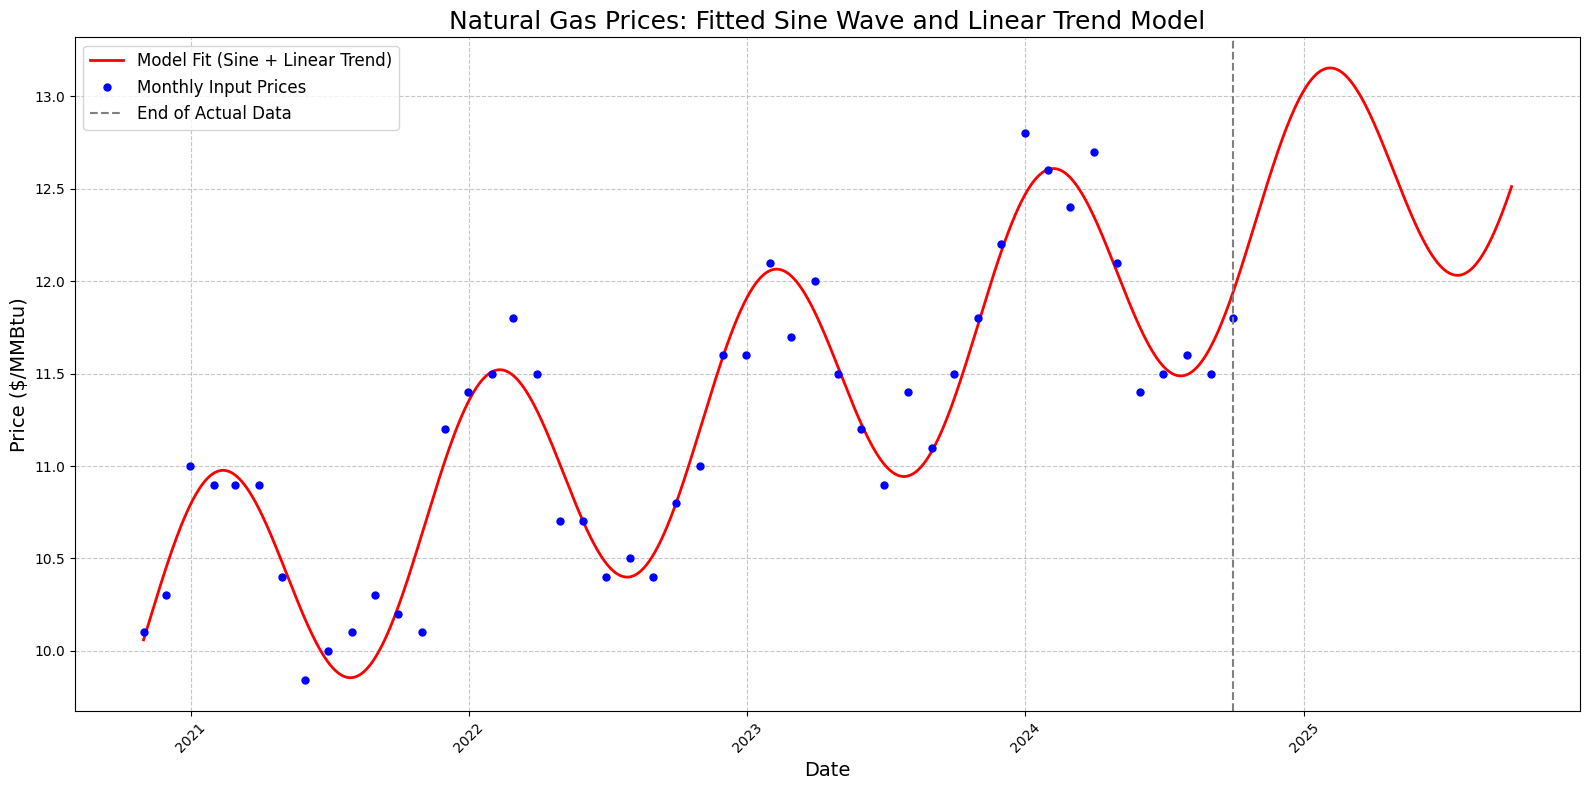


--- Model Evaluation: Backtesting ---
Backtesting Period: 2023-10-31 to 2024-09-30
Number of test points: 12
Mean Absolute Error (MAE): $0.16
Root Mean Squared Error (RMSE): $0.20


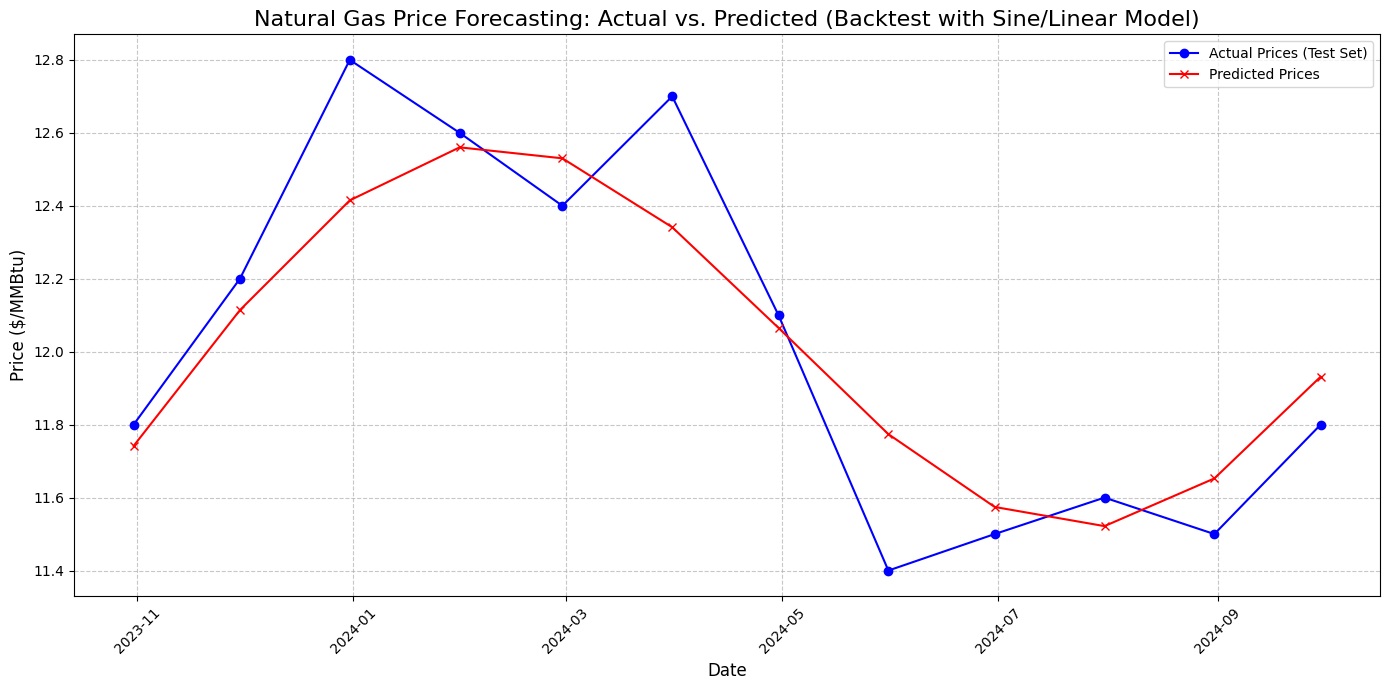

In [42]:
# Define start and end dates from the dataset
start_date = df.index.min()
end_date = df.index.max()

# Calculate days from the start date for numerical representation
days_from_start = (df.index - start_date).days.values

# Define the Model Function for Curve Fitting:
# A combination of a sine wave (for seasonality) and a linear trend.

def combined_model(x, amplitude, frequency, phase_shift, slope, intercept):
    return amplitude * np.sin(frequency * x + phase_shift) + slope * x + intercept

# Fit the Model to the Data
# intercept: Initial guess from the start price
initial_guess = [
    df['Prices'].max() - df['Prices'].min(), # Amplitude
    2 * np.pi / 365,                         # Frequency for annual cycle
    0,                                       # Phase shift
    (df['Prices'].iloc[-1] - df['Prices'].iloc[0]) / len(days_from_start), # Slope estimate
    df['Prices'].iloc[0]                     # Intercept estimate
]

popt, pcov = curve_fit(combined_model, days_from_start, prices, p0=initial_guess)
amplitude, frequency, phase_shift, slope, intercept = popt

# Need 'slope1' and 'slope2' for the sine component
# If y = A * sin(omega * x + phi) + B * x + C
# And y = (A*cos(phi)) * sin(omega*x) + (A*sin(phi)) * cos(omega*x) + B*x + C
# Then slope1 = A*cos(phi) and slope2 = A*sin(phi)

fit_slope = slope
fit_intercept = intercept
fit_amplitude = amplitude
fit_shift = phase_shift

def interpolate(date):
    days = (date - start_date).days
    return combined_model(days, amplitude, frequency, phase_shift, slope, intercept)

# Generate Continuous Dates and Plotting
plot_end_date = end_date + pd.DateOffset(years=1)
continuous_dates = pd.date_range(start=start_date, end=plot_end_date, freq='D')

# Calculate smoothed estimates for the continuous date range
smoothed_estimates = [interpolate(date) for date in continuous_dates]

plt.figure(figsize=(16, 8))
plt.plot(continuous_dates, smoothed_estimates, label='Model Fit (Sine + Linear Trend)', color='red', linewidth=2)
plt.plot(dates, prices, 'o', label='Monthly Input Prices', color='blue', markersize=5)
plt.axvline(end_date, color='grey', linestyle='--', label='End of Actual Data')

plt.xlabel('Date', fontsize=14)
plt.ylabel('Price ($/MMBtu)', fontsize=14)
plt.title('Natural Gas Prices: Fitted Sine Wave and Linear Trend Model', fontsize=18)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n--- Model Evaluation: Backtesting ---")

split_date_backtest = pd.to_datetime('2023-09-30') # 1 year before end of data

if split_date_backtest <= df.index.min() or split_date_backtest >= df.index.max():
    print("Not enough data to perform a meaningful backtest with this split date.")
else:
    train_df_backtest = df[df.index <= split_date_backtest].copy()
    test_df_backtest = df[df.index > split_date_backtest].copy()

    # Get days from start for training data
    train_days_from_start = (train_df_backtest.index - start_date).days.values
    train_prices = train_df_backtest['Prices'].values

    # Fit the model ONLY on the training data
    popt_train, pcov_train = curve_fit(combined_model, train_days_from_start, train_prices, p0=initial_guess)
    amplitude_train, frequency_train, phase_shift_train, slope_train, intercept_train = popt_train

    predictions = []
    actuals = []

    # Predict for the test period
    for date_to_predict in test_df_backtest.index:
        days_predict = (date_to_predict - start_date).days
        predicted_price = combined_model(days_predict, amplitude_train, frequency_train, phase_shift_train, slope_train, intercept_train)
        predictions.append(predicted_price)
        actuals.append(test_df_backtest.loc[date_to_predict]['Prices'])

    if len(predictions) > 0:
        mae = mean_absolute_error(actuals, predictions)
        rmse = np.sqrt(mean_squared_error(actuals, predictions))

        print(f"Backtesting Period: {test_df_backtest.index.min().strftime('%Y-%m-%d')} to {test_df_backtest.index.max().strftime('%Y-%m-%d')}")
        print(f"Number of test points: {len(predictions)}")
        print(f"Mean Absolute Error (MAE): ${mae:.2f}")
        print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")

        # Visualize backtesting results
        plt.figure(figsize=(14, 7))
        plt.plot(test_df_backtest.index, actuals, 'o-', label='Actual Prices (Test Set)', color='blue')
        plt.plot(test_df_backtest.index, predictions, 'x-', label='Predicted Prices', color='red')
        plt.title('Natural Gas Price Forecasting: Actual vs. Predicted (Backtest with Sine/Linear Model)', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Price ($/MMBtu)', fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("No predictions generated for backtesting. Check split date or data.")



## Task 2: Natural Gas Storage Contract Valuation

### Objective
- To develop a simulation model for valuing natural gas storage contracts by meticulously tracking gas flow, associated costs, and revenues over the contract's lifecycle. The aim is to determine the net profitability of such a contract under given market conditions and operational parameters.

### Core Function: `price_contract`

This function serves as the central engine for the storage contract simulation.

#### Purpose
- Simulates the sequential injection and withdrawal of natural gas into and from a storage facility.
- Calculates the total costs incurred (gas purchases, injection fees, storage fees) and total revenues generated (gas sales, net of withdrawal fees).
- Determines the overall net profit or loss of the contract.

#### Inputs
- **`in_dates` (list of `pd.Timestamp`):** A list of dates when natural gas is injected into storage. These dates should correspond positionally with `in_prices`.
- **`in_prices` (list of float):** A list of prices (USD/MMBtu) at which gas is purchased for injection, corresponding to `in_dates`.
- **`out_dates` (list of `pd.Timestamp`):** A list of dates when natural gas is withdrawn from storage and sold. These dates should correspond positionally with `out_prices`.
- **`out_prices` (list of float):** A list of prices (USD/MMBtu) at which gas is sold upon withdrawal, corresponding to `out_dates`.
- **`rate` (float):** The fixed volume of natural gas (e.g., MMBtu) injected or withdrawn in each operation.
- **`storage_cost_rate` (float):** The fixed monthly cost (e.g., USD) for maintaining the storage facility, regardless of volume.
- **`total_vol` (float):** The maximum storage capacity of the facility (e.g., MMBtu).
- **`injection_withdrawal_cost_rate` (float):** The per-unit cost (e.g., USD/MMBtu) associated with injecting or withdrawing gas (applied to `rate`).

#### Outputs
- **Return Value (float):** The `net_profit` of the contract (Total Cash In - Total Buy Cost - Total Storage Cost). A positive value indicates profit, a negative value indicates a loss.
- **Console Output (Printed Trace):**
    - A step-by-step log of each injection and withdrawal operation, including:
        - Date of operation.
        - Volume injected/extracted.
        - Price at which transaction occurred.
        - Associated injection/withdrawal fees.
        - Current volume of gas in storage.
    - Summary of the total storage duration and its calculated cost.
    - The calculated `net_profit` formatted to two decimal places.
    - A clear conclusion stating whether the contract is "PROFITABLE," "UNPROFITABLE," or "BREAK EVEN."

### Simulation Logic & Methodology

- **Chronological Processing:** All injection and withdrawal dates are combined, deduplicated, and sorted to ensure operations are processed in the correct time sequence.
- **Volume Management:** A running `volume` counter tracks the gas in storage. Each operation checks against the `total_vol` capacity for injections and `volume >= rate` for withdrawals to ensure physical feasibility. Messages are printed if operations cannot proceed due to constraints.
- **Financial Accounting:**
    - `buy_cost`: Accumulates the cost of purchasing gas plus injection fees.
    - `cash_in`: Accumulates revenue from selling gas minus withdrawal fees.
- **Storage Cost Calculation:**
    - Determined by the span of time between the first and last operation dates.
    - Converted to months (`math.ceil(days / 30.0)`) and multiplied by `storage_cost_rate`.
- **Profitability Determination:** The final `net_profit` is calculated. A small numerical `tolerance` (e.g., `1e-6`) is applied when comparing `net_profit` to zero to account for potential floating-point inaccuracies, ensuring that very small positive or negative values are correctly identified as "BREAK EVEN."

### Practical Application and Significance

- **Contract Valuation:** This model provides a direct method for valuing a natural gas storage contract, essential for trading decisions.
- **Risk Assessment:** By running simulations with varying price scenarios (e.g., using price forecasts from Task 1), traders can assess potential profitability and risk exposures.
- **Operational Planning:** The volume tracking and capacity constraints help understand the operational feasibility of a proposed contract.
- **Transparency:** The detailed print output is invaluable for quant traders to audit the model's calculations and verify the source of profit or loss, fostering trust in the model's results.

### Illustrative Examples

The code includes three distinct examples to demonstrate the function's behavior:
- **Profitable Contract:** Shows a scenario where buy prices are lower than sell prices, and revenues significantly outweigh costs.
- **Unprofitable Contract:** Illustrates a scenario where higher buy prices, lower sell prices, and/or increased operational/storage costs lead to a net loss.
- **Break-Even Contract:** A carefully constructed example designed to result in a net profit of approximately zero, demonstrating the `tolerance` handling in the profitability conclusion.

In [43]:
def price_contract(in_dates, in_prices, out_dates, out_prices, rate, storage_cost_rate, total_vol, injection_withdrawal_cost_rate):
    """
    Calculates the profitability of a natural gas storage contract.

    This function simulates the injection and withdrawal of natural gas from storage
    over a period, accounting for buying costs, selling revenues, storage costs,
    and injection/withdrawal fees.
    """
    volume = 0.0 # Current volume of gas in storage
    buy_cost = 0.0 # Total cost incurred from buying and injecting gas
    cash_in = 0.0 # Total revenue generated from selling and withdrawing gas

    all_dates = sorted(set(in_dates + out_dates))

    print("--- Simulating Gas Storage Operations ---")
    for current_date in all_dates:
        if current_date in in_dates:
            if volume <= total_vol - rate:
                volume += rate # Increase stored volume
                # Get the price for the current injection date
                price = in_prices[in_dates.index(current_date)]
                injection_cost = rate * injection_withdrawal_cost_rate # Calculate injection fee
                buy_cost += (rate * price) + injection_cost # Add to total buy cost

                print(f'   On {current_date.strftime("%Y-%m-%d")}: Injected {rate} units at ${price:.2f}. Injection cost: ${injection_cost:.2f}. Current volume: {volume}')
            else:
                print(f'   On {current_date.strftime("%Y-%m-%d")}: Injection not possible. Insufficient storage capacity. Volume: {volume}/{total_vol}')

        elif current_date in out_dates:
            if volume >= rate:
                volume -= rate # Decrease stored volume
                price = out_prices[out_dates.index(current_date)]
                withdrawal_cost = rate * injection_withdrawal_cost_rate # Calculate withdrawal fee
                cash_in += (rate * price) - withdrawal_cost # Add to total cash in

                print(f'   On {current_date.strftime("%Y-%m-%d")}: Extracted {rate} units at ${price:.2f}. Withdrawal cost: ${withdrawal_cost:.2f}. Current volume: {volume}')
            else:
                print(f'   On {current_date.strftime("%Y-%m-%d")}: Extraction not possible. Insufficient stored gas. Volume: {volume}')

    if in_dates and out_dates:
        min_operation_date = min(min(in_dates), min(out_dates))
        max_operation_date = max(max(in_dates), max(out_dates))
        storage_duration_days = (max_operation_date - min_operation_date).days
        storage_duration_months = math.ceil(storage_duration_days / 30.0)
        store_cost = storage_duration_months * storage_cost_rate
        print(f"\nStorage duration: {storage_duration_months} months (based on {storage_duration_days} days). Total storage cost: ${store_cost:.2f}")
    else:
        store_cost = 0.0
        print("\nNo valid injection/extraction dates found to calculate storage duration.")

    # Calculate the net profit/loss
    net_profit = cash_in - store_cost - buy_cost

    print(f"\n--- Contract Summary ---")
    print(f"The calculated value of the contract is: ${net_profit:,.2f}")

    tolerance = 1e-6 # Define a small tolerance for floating-point comparison

    if net_profit > tolerance:
        print("Conclusion: The contract is expected to be PROFITABLE.")
    elif net_profit < -tolerance: # Check if it's significantly negative
        print("Conclusion: The contract is expected to be UNPROFITABLE.")
    else: # Within the tolerance of zero
        print("Conclusion: The contract is expected to BREAK EVEN (zero profit).")

    return net_profit

In [44]:
# --- Example 1: Profitable Contract ---
print("\n" + "="*50)
print("Running Example 1: Profitable Contract Simulation:")
print("="*50)

in_dates_profitable = [
    pd.Timestamp(2023, 1, 15),
    pd.Timestamp(2023, 3, 10),
    pd.Timestamp(2023, 4, 1)
]
in_prices_profitable = [3.00, 3.20, 3.10] # Buy low

out_dates_profitable = [
    pd.Timestamp(2023, 8, 1),
    pd.Timestamp(2023, 10, 20),
    pd.Timestamp(2024, 1, 5)
]
out_prices_profitable = [4.50, 4.80, 4.00] # Sell high

# Contract parameters
rate_profitable = 100000
storage_cost_rate_profitable = 12000
max_storage_volume_profitable = 300000
injection_withdrawal_cost_rate_profitable = 0.05

final_profit_profitable = price_contract(
    in_dates_profitable,
    in_prices_profitable,
    out_dates_profitable,
    out_prices_profitable,
    rate_profitable,
    storage_cost_rate_profitable,
    max_storage_volume_profitable,
    injection_withdrawal_cost_rate_profitable
)

# --- Example 2: Unprofitable Contract ---
print("\n" + "="*50)
print("Running Example 2: Unprofitable Contract Simulation (High Costs / Low Sale Prices):")
print("="*50)

in_dates_unprofitable = [
    pd.Timestamp(2023, 1, 15),
    pd.Timestamp(2023, 3, 10),
    pd.Timestamp(2023, 4, 1)
]
in_prices_unprofitable = [4.50, 4.80, 4.00] # Buying at higher prices

out_dates_unprofitable = [
    pd.Timestamp(2023, 8, 1),
    pd.Timestamp(2023, 10, 20),
    pd.Timestamp(2024, 1, 5)
]
out_prices_unprofitable = [3.00, 3.20, 3.10] # Selling at lower prices

rate_unprofitable = 100000
storage_cost_rate_unprofitable = 15000 # Increased storage cost
max_storage_volume_unprofitable = 300000
injection_withdrawal_cost_rate_unprofitable = 0.10 # Increased injection/withdrawal cost

final_profit_unprofitable = price_contract(
    in_dates_unprofitable,
    in_prices_unprofitable,
    out_dates_unprofitable,
    out_prices_unprofitable,
    rate_unprofitable,
    storage_cost_rate_unprofitable,
    max_storage_volume_unprofitable,
    injection_withdrawal_cost_rate_unprofitable
)

# --- Example 3: Break-Even (BE) Contract ---
print("\n" + "="*50)
print("Running Example 3: Break-Even Contract Simulation:")
print("="*50)

# Try to make (Cash In - Buy Cost - Storage Cost) approximately zero.
in_dates_be = [
    pd.Timestamp(2024, 6, 1)
]
in_prices_be = [10.00] # Buy price

out_dates_be = [
    pd.Timestamp(2024, 7, 1)
]
out_prices_be = [12.00] # Sell price

rate_be = 100000 # Keep rate high to make total values clear
storage_cost_rate_be = 100000 # Adjust this for break-even
max_storage_volume_be = 100000
injection_withdrawal_cost_rate_be = 1.00 # $1 per unit fee

storage_cost_rate_be = 0.0 # Temporarily set to 0 to demonstrate pure BE from trades
injection_withdrawal_cost_rate_be = 0.01

in_dates_be = [pd.Timestamp(2024, 6, 1)]
in_prices_be = [10.00]

out_dates_be = [pd.Timestamp(2024, 7, 1)]
out_prices_be = [10.20]

rate_be = 100000
injection_withdrawal_cost_rate_be = 0.05 # Fees
storage_cost_rate_be = 10000 # Monthly storage cost

# Expected outcome for this example:
# Buy cost: (100000 * 10.00) + (100000 * 0.05) = 1,000,000 + 5,000 = 1,005,000
# Cash in: (100000 * 10.20) - (100000 * 0.05) = 1,020,000 - 5,000 = 1,015,000
# Storage duration: 1 month (30 days)
# Storage cost: 1 * 10000 = 10,000
# Net profit = 1,015,000 (Cash In) - 1,005,000 (Buy Cost) - 10,000 (Storage Cost)
# Net profit = 10,000 - 10,000 = 0

final_profit_be = price_contract(
    in_dates_be,
    in_prices_be,
    out_dates_be,
    out_prices_be,
    rate_be,
    storage_cost_rate_be,
    max_storage_volume_be,
    injection_withdrawal_cost_rate_be
)


Running Example 1: Profitable Contract Simulation:
--- Simulating Gas Storage Operations ---
   On 2023-01-15: Injected 100000 units at $3.00. Injection cost: $5000.00. Current volume: 100000.0
   On 2023-03-10: Injected 100000 units at $3.20. Injection cost: $5000.00. Current volume: 200000.0
   On 2023-04-01: Injected 100000 units at $3.10. Injection cost: $5000.00. Current volume: 300000.0
   On 2023-08-01: Extracted 100000 units at $4.50. Withdrawal cost: $5000.00. Current volume: 200000.0
   On 2023-10-20: Extracted 100000 units at $4.80. Withdrawal cost: $5000.00. Current volume: 100000.0
   On 2024-01-05: Extracted 100000 units at $4.00. Withdrawal cost: $5000.00. Current volume: 0.0

Storage duration: 12 months (based on 355 days). Total storage cost: $144000.00

--- Contract Summary ---
The calculated value of the contract is: $226,000.00
Conclusion: The contract is expected to be PROFITABLE.

Running Example 2: Unprofitable Contract Simulation (High Costs / Low Sale Prices):

# Loan Data & Credit Risk Analysis:

## Task 3: Credit Risk Modeling and Expected Loss Calculation

### Objective
- To build a predictive model for loan default (Probability of Default - PD) using historical loan data.
- To develop a function that calculates the Expected Loss (EL) for a given loan, incorporating the predicted PD, Loss Given Default (LGD), and Exposure at Default (EAD).

### Dataset Overview
- **Source**: `Task 3 and 4_Loan_Data.csv` (provided as part of the job simulation).
- **Column Headers and Descriptions**:
    - **`customer_id`**: A unique identifier for each customer. (This column is typically dropped before model training as it's not a predictive feature).
    - **`credit_lines_outstanding`**: The number of open credit lines (e.g., credit cards, loans) a customer currently has.
    - **`loan_amt_outstanding`**: The current outstanding balance on the loan being assessed. This is also used as Exposure at Default (EAD) in the EL calculation and for feature engineering.
    - **`total_debt_outstanding`**: The total amount of all outstanding debt (including the current loan and other credit lines) for the customer. Used for feature engineering.
    - **`income`**: The customer's annual income. Used for feature engineering.
    - **`years_employed`**: The number of years the customer has been employed in their current or previous jobs.
    - **`fico_score`**: The customer's FICO credit score, a widely used credit risk indicator. Higher scores indicate lower credit risk.
    - **`default`**: The target variable. A binary indicator where `1` signifies the loan has defaulted, and `0` signifies the loan has not defaulted.

### Key Analysis Components

#### 1. Data Loading and Feature Engineering
- **Loading**: The loan dataset is loaded into a Pandas DataFrame. Error handling is included for `FileNotFoundError`.
- **Feature Derivation**: Two critical credit risk ratios are engineered:
    - **`payment_to_income`**: `loan_amt_outstanding / income`. Represents the burden of the current loan relative to income. Handled division by zero for income.
    - **`debt_to_income`**: `total_debt_outstanding / income`. Represents the overall debt burden relative to income. Handled division by zero for income.
- **Feature Selection**: A specific set of features (`credit_lines_outstanding`, `debt_to_income`, `payment_to_income`, `years_employed`, `fico_score`) is chosen for model training.

#### 2. Data Preparation for Modeling
- **Feature (`X`) and Target (`y`) Definition**: The selected features form `X`, and the `default` column is the target `y`.
- **Train-Test Split**: The data is split into 70% training and 30% testing sets using `train_test_split`. `stratify=y` is used to ensure that the proportion of defaulting and non-defaulting loans is maintained in both sets, which is crucial for imbalanced datasets.
- **Feature Scaling**: `StandardScaler` is fitted on the training data and then used to transform both training and testing sets. This standardizes features to a mean of 0 and a standard deviation of 1, which is important for algorithms like Logistic Regression that are sensitive to feature scales.

#### 3. Logistic Regression Model Training
- **Model Choice**: A Logistic Regression model is chosen for predicting the Probability of Default (PD), given its interpretability and effectiveness in binary classification.
- **Parameters**: `random_state=42` ensures reproducibility. `solver='liblinear'` is a good choice for smaller datasets and for handling L1/L2 regularization. `tol=1e-5` and `max_iter=10000` control convergence criteria.
- **Fitting**: The model is trained (`fit`) on the `scaled` training data.

#### 4. Model Evaluation
- **Coefficients and Intercept**: The learned coefficients for each feature and the model's intercept are printed, offering insights into how each factor influences the likelihood of default.
- **Misclassification Rate**: Calculated as `1 - accuracy` on the test set, indicating the proportion of incorrect predictions.
- **ROC AUC Score**: The Area Under the Receiver Operating Characteristic Curve (AUC) is calculated. This metric measures the model's ability to distinguish between defaulting and non-defaulting loans across all possible classification thresholds, providing a comprehensive view of performance.

#### 5. Expected Loss (EL) Calculation Framework

A dedicated function `calculate_expected_loss` is developed to compute the Expected Loss for individual loan applications, based on the fundamental credit risk formula:
$$EL = PD \times LGD \times EAD$$

- **`calculate_expected_loss` Function**:
    - **Inputs**: Takes `loan_properties` (a dictionary of loan characteristics), the `trained_model` (Logistic Regression), the `feature_scaler`, the `original_feature_names` used by the model, and a `recovery_rate` (defaulting to 10%).
    - **Internal Feature Engineering**: Critically, the function *re-calculates* `payment_to_income` and `debt_to_income` ratios from the raw loan properties provided (if `income`, `loan_amt_outstanding`, `total_debt_outstanding` are present). This ensures consistency with the features the model was trained on.
    - **Probability of Default (PD)**: Predicted by the `trained_model` using `predict_proba`. This is the probability that the loan will default.
    - **Loss Given Default (LGD)**: Calculated as `1 - recovery_rate`. This represents the proportion of the exposure that is lost if default occurs.
    - **Exposure at Default (EAD)**: Directly taken from `loan_properties['loan_amt_outstanding']`, representing the outstanding amount at the time of default.
    - **Output**: Returns the calculated Expected Loss and provides a detailed printout of the inputs, intermediate values (PD, LGD, EAD), and the final EL. Robust error handling is implemented for missing properties or unexpected issues.

#### 6. Example Usage of Expected Loss Function
- The `calculate_expected_loss` function is demonstrated with various loan scenarios:
    - A hypothetical "healthy" loan, expected to have low PD and EL.
    - A hypothetical "risky" loan, expected to have high PD and EL.
    - An example using data from an existing non-defaulting customer from the dataset.
    - An example using data from an existing defaulting customer from the dataset, showcasing how EL differs for actual defaulters.


In [50]:
# --- Load New Data ---
df = pd.read_csv('Task 3 and 4_Loan_Data.csv')
print("Dataset loaded successfully.")

# --- Feature Engineering ---
# Calculate the payment_to_income ratio
df['payment_to_income'] = df.apply(
    lambda row: row['loan_amt_outstanding'] / row['income'] if row['income'] != 0 else 0,
    axis=1
)
# Calculate the debt_to_income ratio
df['debt_to_income'] = df.apply(
    lambda row: row['total_debt_outstanding'] / row['income'] if row['income'] != 0 else 0,
    axis=1
)
print("Engineered 'payment_to_income' and 'debt_to_income' features.")

# --- Prepare Data for Model Training ---
features = ['credit_lines_outstanding', 'debt_to_income', 'payment_to_income', 'years_employed', 'fico_score']
X = df[features]
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Data split into {len(X_train)} training samples and {len(X_test)} testing samples.")

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features scaled using StandardScaler.")

# --- Train Logistic Regression Model ---
model = LogisticRegression(random_state=42, solver='liblinear', tol=1e-5, max_iter=10000)
model.fit(X_train_scaled, y_train)
print("\nLogistic Regression model trained successfully.")

# --- Model Evaluation ---
print("\n--- Model Coefficients and Intercept ---")
print(f"Features: {features}")
print(f"Coefficients: {model.coef_[0]}")
print(f"Intercept: {model.intercept_[0]}")

# Predictions
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# Misclassification Rate (1 - Accuracy)
misclassification_rate = (1.0 * (abs(y_test - y_pred)).sum()) / len(y_test)
print(f"\nMisclassification Rate on Test Set: {misclassification_rate:.4f}")

# ROC, AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba)
roc_auc = metrics.auc(fpr, tpr)
print(f"ROC AUC Score on Test Set: {roc_auc:.4f}")

# --- Expected Loss Function ---
def calculate_expected_loss(loan_properties: dict, trained_model: LogisticRegression, feature_scaler: StandardScaler, original_feature_names: list, recovery_rate: float = 0.10) -> float:
    """
    Calculates the Expected Loss (EL = PD * LGD * EAD) for a given loan.
    """
    try:
        loan_df = pd.DataFrame([loan_properties])
        if 'loan_amt_outstanding' in loan_df.columns and 'income' in loan_df.columns:
            loan_df['payment_to_income'] = loan_df.apply(
                lambda row: row['loan_amt_outstanding'] / row['income'] if row['income'] != 0 else 0,
                axis=1
            )

        if 'total_debt_outstanding' in loan_df.columns and 'income' in loan_df.columns:
            loan_df['debt_to_income'] = loan_df.apply(
                lambda row: row['total_debt_outstanding'] / row['income'] if row['income'] != 0 else 0,
                axis=1
            )

        input_features = loan_df[original_feature_names]
        # Scale the input features
        scaled_features = feature_scaler.transform(input_features)

        # Predict Probability of Default (PD)
        pd_value = trained_model.predict_proba(scaled_features)[:, 1][0]

        # Calculate Loss Given Default (LGD)
        lgd = 1 - recovery_rate

        # Get Exposure at Default (EAD)
        if 'loan_amt_outstanding' not in loan_properties:
            raise ValueError("loan_amt_outstanding must be provided in loan_properties for EAD calculation.")
        ead = loan_properties['loan_amt_outstanding']

        # Calculate Expected Loss
        expected_loss = pd_value * lgd * ead

        print(f"\n--- Expected Loss Calculation for Loan ---")
        print(f"Loan Properties: {loan_properties}")
        print(f"Predicted PD: {pd_value:.4f}")
        print(f"LGD (1 - Recovery Rate): {lgd:.2f}")
        print(f"EAD (Loan Amount Outstanding): ${ead:,.2f}")
        print(f"Calculated Expected Loss: ${expected_loss:,.2f}")

        return expected_loss

    except KeyError as e:
        print(f"Error: Missing loan property for expected loss calculation: {e}. Please ensure all required features are provided or can be derived.")
        return 0
    except ValueError as e:
        print(f"Error: {e}")
        return 0
    except Exception as e:
        print(f"An unexpected error occurred during expected loss calculation: {e}")
        return 0

# --- Example Usage ---

# Example 1: A "healthy" loan (low PD, low EL)
example_loan_healthy = {
    'credit_lines_outstanding': 1,
    'loan_amt_outstanding': 2000.00,
    'total_debt_outstanding': 1000.00,
    'income': 90000.00,
    'years_employed': 8,
    'fico_score': 750
}

print("\n" + "="*50)
print("Calculating EL for a relatively Healthy Loan:")
print("="*50)
expected_loss_healthy_loan = calculate_expected_loss(
    loan_properties=example_loan_healthy,
    trained_model=model,
    feature_scaler=scaler,
    original_feature_names=features,
    recovery_rate=0.10
)

# Example 2: A "risky" loan (high PD, high EL)
example_loan_risky = {
    'credit_lines_outstanding': 5,
    'loan_amt_outstanding': 15000.00,
    'total_debt_outstanding': 40000.00,
    'income': 35000.00,
    'years_employed': 1,
    'fico_score': 580
}
print("\n" + "="*50)
print("Calculating EL for a relatively Risky Loan:")
print("="*50)
expected_loss_risky_loan = calculate_expected_loss(
    loan_properties=example_loan_risky,
    trained_model=model,
    feature_scaler=scaler,
    original_feature_names=features,
    recovery_rate=0.10
)

# Example 3: Using an existing non-defaulting customer from the dataset
first_customer_original_data = df.iloc[0].to_dict()
first_customer_loan_props = {
    k: first_customer_original_data[k] for k in ['loan_amt_outstanding', 'total_debt_outstanding', 'income',
                                                  'credit_lines_outstanding', 'years_employed', 'fico_score']
}

print("\n" + "="*50)
print("Calculating EL for an Existing Customer (first row, actual default=0):")
print("="*50)
expected_loss_first_customer = calculate_expected_loss(
    loan_properties=first_customer_loan_props,
    trained_model=model,
    feature_scaler=scaler,
    original_feature_names=features,
    recovery_rate=0.10
)

# Example 4: Using an existing defaulting customer from the dataset
defaulting_customers = df[df['default'] == 1]
if not defaulting_customers.empty:
    sample_defaulting_customer_original_data = defaulting_customers.iloc[0].to_dict()
    sample_defaulting_customer_loan_props = {
        k: sample_defaulting_customer_original_data[k] for k in ['loan_amt_outstanding', 'total_debt_outstanding', 'income',
                                                                  'credit_lines_outstanding', 'years_employed', 'fico_score']
    }
    print("\n" + "="*50)
    print("Calculating EL for an Existing Defaulting Customer (first actual default=1):")
    print("="*50)
    expected_loss_default_customer = calculate_expected_loss(
        loan_properties=sample_defaulting_customer_loan_props,
        trained_model=model,
        feature_scaler=scaler,
        original_feature_names=features,
        recovery_rate=0.10
    )
else:
    print("\nNo defaulting customers found in the dataset for a specific example.")

Dataset loaded successfully.
Engineered 'payment_to_income' and 'debt_to_income' features.
Data split into 7000 training samples and 3000 testing samples.
Features scaled using StandardScaler.

Logistic Regression model trained successfully.

--- Model Coefficients and Intercept ---
Features: ['credit_lines_outstanding', 'debt_to_income', 'payment_to_income', 'years_employed', 'fico_score']
Coefficients: [ 5.6307341   2.86001089  0.06595345 -1.90472563 -0.80257122]
Intercept: -9.20972009990534

Misclassification Rate on Test Set: 0.0017
ROC AUC Score on Test Set: 1.0000

Calculating EL for a relatively Healthy Loan:

--- Expected Loss Calculation for Loan ---
Loan Properties: {'credit_lines_outstanding': 1, 'loan_amt_outstanding': 2000.0, 'total_debt_outstanding': 1000.0, 'income': 90000.0, 'years_employed': 8, 'fico_score': 750}
Predicted PD: 0.0000
LGD (1 - Recovery Rate): 0.90
EAD (Loan Amount Outstanding): $2,000.00
Calculated Expected Loss: $0.00

Calculating EL for a relatively R

## Task 4: FICO Score Quantization and Rating System Development

### Objective
- To categorize continuous FICO credit scores into discrete "buckets" or "ratings".
- To develop and compare two different quantization methodologies: one based on minimizing Mean Squared Error (K-Means Clustering) and another based on maximizing Log-Likelihood (Dynamic Programming).
- The ultimate goal is to create a more interpretable credit rating system where each bucket represents a distinct risk profile, particularly with respect to default probability.

### Dataset Used
- The same `Task 3 and 4_Loan_Data.csv` dataset as in Task 3.
- Focus is primarily on the `fico_score` column and its relationship with the `default` status.
- **Data Preprocessing**: FICO scores are converted to numeric, and rows with missing FICO or default status are dropped. `default` status is ensured to be integer type.

### Core Concepts

- **Quantization (Binning)**: The process of transforming a continuous numerical variable (like FICO score, which can range from 300 to 850) into a set of discrete intervals or "bins." This is done for:
    - **Interpretability**: Easier to understand "good," "average," "poor" credit tiers than precise score numbers.
    - **Risk Grouping**: Loans within the same bucket are expected to have similar risk characteristics.
    - **Regulatory Compliance**: Many financial regulations require credit risk to be assessed using rating grades.
- **Credit Rating System**: A system that assigns a categorical rating (e.g., A, B, C or 1, 2, 3) to a borrower based on their credit score and other risk factors. In this task, FICO scores are mapped to numerical ratings (e.g., 1 for best credit, 5 for worst credit).

### Quantization Methodologies

#### 1. Minimizing Mean Squared Error (MSE) using K-Means Clustering

- **Purpose**: This method aims to group FICO scores such that the variance within each cluster (bucket) is minimized. It focuses on the distribution of the FICO scores themselves, attempting to create groups that are as homogeneous as possible in terms of the score value.
- **Function**: `quantize_fico_kmeans(fico_scores, n_buckets)`
- **Process**:
    1.  **Clustering**: K-Means clustering is applied directly to the FICO scores to identify `n_buckets` optimal cluster centers.
    2.  **Boundary Definition**: The boundaries between buckets are set at the midpoints between the sorted cluster centers.
    3.  **Rating Mapping**: Each FICO score is then assigned to a rating (1 to `n_buckets`), with lower ratings (e.g., 1) corresponding to higher (better) FICO scores.
- **Outputs**:
    - `K-Means (MSE) Cluster Centers`: The central value for each FICO bucket.
    - `K-Means (MSE) Derived Boundaries`: The FICO score thresholds defining each bucket.
    - `FICO Ratings (K-Means) Value Counts`: Distribution of loans across the created ratings.
    - `Mean FICO Score and Default Rate per K-Means Rating`: Summary statistics showing the average FICO and average default rate within each K-Means derived rating.

#### 2. Maximizing Log-Likelihood using Dynamic Programming

- **Purpose**: This method is specifically designed for credit risk grading. Instead of just minimizing within-cluster variance of FICO scores, it aims to create buckets that maximize the statistical likelihood of observing the default outcomes *within those bins*. This means it tries to find cut-off points that result in the most distinct default rates between adjacent buckets. It's often preferred for PD modeling.
- **Functions**:
    - `calculate_segment_log_likelihood(n, k)`: A helper function that computes the log-likelihood for a given segment of data (n total records, k defaults). It uses a Bernoulli distribution's likelihood.
    - `quantize_fico_log_likelihood(fico_scores, defaults, n_buckets)`: The main function that implements the dynamic programming algorithm.
- **Process**:
    1.  **Data Preparation**: FICO scores and their corresponding default statuses are sorted together by FICO score.
    2.  **Prefix Sums**: Pre-calculated arrays (`total_counts`, `default_counts`) are used to efficiently determine the number of total records and defaults in any given segment.
    3.  **Dynamic Programming (DP) Table**: A `dp_table` stores the maximum log-likelihood achievable for data up to a certain index using a certain number of buckets. A `path_table` records the optimal split points.
    4.  **Backtracking**: After the DP table is filled, the optimal bucket boundaries are reconstructed by backtracking through the `path_table`.
    5.  **Rating Mapping**: Similar to K-Means, FICO scores are mapped to ratings (1 to `n_buckets`), with 1 representing the highest FICO scores.
- **Computational Complexity Note**: This Dynamic Programming algorithm has a time complexity of approximately $O(N^2 \cdot K)$, where $N$ is the number of data points and $K$ is the number of buckets. For very large datasets, this method can be computationally intensive and may take a significant amount of time to execute.
- **Outputs**:
    - `Log-Likelihood (DP) Optimal Boundaries`: The FICO score thresholds derived by the algorithm.
    - `FICO Ratings (Log-Likelihood) Value Counts`: Distribution of loans across the created ratings.
    - `Mean FICO Score and Default Rate per Log-Likelihood Rating`: Summary statistics showing the average FICO and average default rate within each Log-Likelihood derived rating.

### Visualizations

- Two histograms are generated using `seaborn.histplot`:
    - One displays the distribution of FICO scores, colored by the K-Means derived ratings.
    - The other displays the distribution of FICO scores, colored by the Log-Likelihood derived ratings.
- Vertical red dashed lines indicate the calculated boundaries for each method, making it easy to visually compare how each method divides the FICO score range.

### Comparative Analysis and Recommendation

- **K-Means (Minimizing MSE)**: Effectively groups scores by their numerical proximity, creating buckets with similar score ranges. However, it does not explicitly consider the `default` outcome when defining boundaries.
- **Log-Likelihood (Maximizing Log-Likelihood)**: Directly optimizes for the "predictiveness" of the bins with respect to default rates. This method aims to create buckets where the default rates are as distinct as possible from one bucket to the next.

**Recommendation for PD Modeling:**
For predicting the Probability of Default (PD) and building a credit risk rating system, the **Log-Likelihood optimization method is generally preferred**. This is because its objective function directly relates to the statistical properties of the default outcome, leading to bins that are more statistically meaningful for differentiating credit risk. While K-Means provides useful general-purpose binning, it doesn't leverage the crucial default information as effectively for this specific application.

Dataset loaded successfully.

--- Quantizing FICO scores into 5 buckets ---

: ###Quantization by Minimizing Mean Squared Error (K-Means) ###
K-Means (MSE) Cluster Centers: [531.37 593.24 640.89 687.2  743.17]
K-Means (MSE) Derived Boundaries: [562.31 617.07 664.05 715.19]
K-Means (MSE) Full Boundaries for Mapping: [300.   562.31 617.07 664.05 715.19 850.  ]

FICO Ratings (K-Means) Value Counts:
fico_rating_kmeans
1     962
2    2353
3    3036
4    2569
5    1080
Name: count, dtype: int64

Mean FICO Score and Default Rate per K-Means Rating:
                     mean_fico  default_rate  count
fico_rating_kmeans                                 
1                   743.170478      0.034304    962
2                   687.201020      0.083723   2353
3                   640.889328      0.147233   3036
4                   593.242118      0.256131   2569
5                   531.374074      0.477778   1080

### Method 2: Quantization by Maximizing Log-Likelihood (Dynamic Programming) ###
Log-L

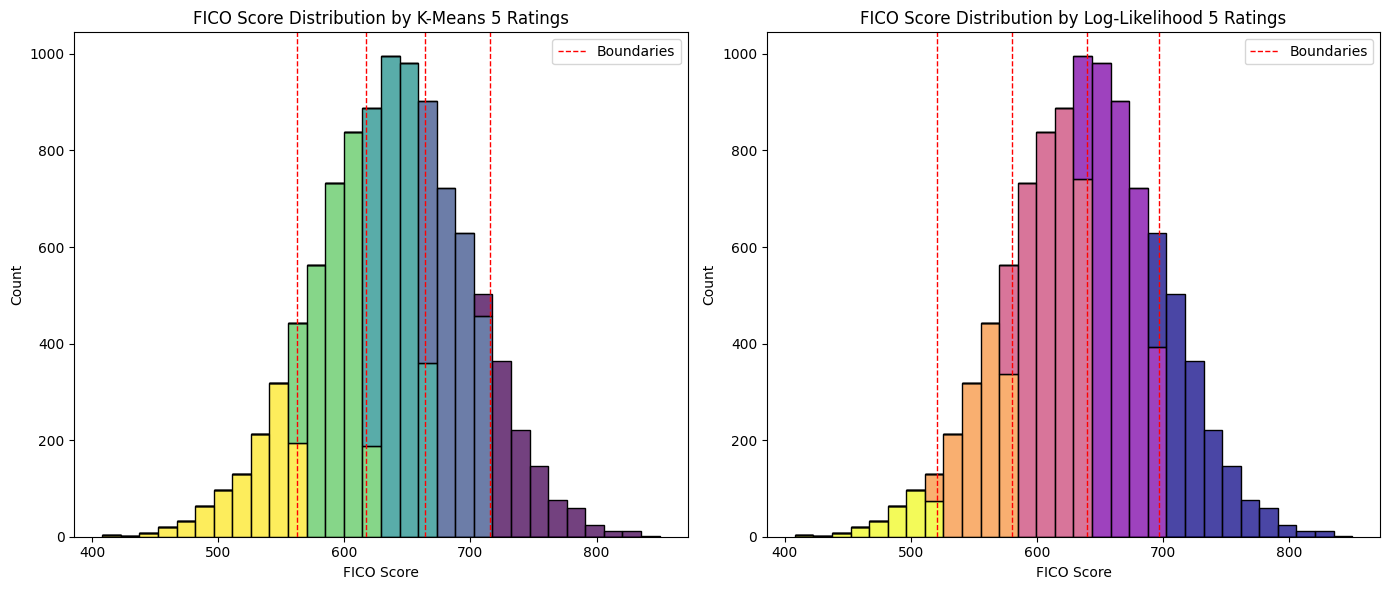


### Comparative Analysis of Quantization Methods ###
Using 5 buckets:

1. K-Means (Minimizing MSE):
   - Boundaries: [300.   562.31 617.07 664.05 715.19 850.  ]

2. Log-Likelihood (Maximizing Log-Likelihood):
   - Boundaries: [300 521 580 640 697 850]

Recommendation:
For predicting the Probability of Default (PD), the **Log-Likelihood optimization method is generally preferred**.
This is because it explicitly considers the default rates within each bucket, leading to bins that are more statistically meaningful for predicting default.
K-Means is a good general-purpose binning method but does not leverage the 'default' information, which is critical for PD modeling.


In [51]:
# --- Same dataset being used as in Task 3 ---
df = pd.read_csv('Task 3 and 4_Loan_Data.csv')
print("Dataset loaded successfully.")

df['fico_score'] = pd.to_numeric(df['fico_score'], errors='coerce')
df.dropna(subset=['fico_score', 'default'], inplace=True)
df['default'] = df['default'].astype(int)

# Extract FICO scores and default status
fico_scores = df['fico_score'].values
defaults = df['default'].values

# Define the number of buckets
NUM_BUCKETS = 5
print(f"\n--- Quantizing FICO scores into {NUM_BUCKETS} buckets ---")

# --- Method 1: Minimizing Mean Squared Error (MSE) using K-Means ---
print("\n: ###Quantization by Minimizing Mean Squared Error (K-Means) ###")

def quantize_fico_kmeans(fico_scores, n_buckets):

    X_fico = fico_scores.reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_buckets, random_state=42, n_init='auto')
    kmeans.fit(X_fico)
    centers = np.sort(kmeans.cluster_centers_.flatten())
    boundaries = [(centers[i] + centers[i+1]) / 2 for i in range(len(centers) - 1)]

    full_boundaries = [fico_scores.min()] + boundaries + [fico_scores.max()]
    if full_boundaries[0] > 300: full_boundaries[0] = 300
    if full_boundaries[-1] < 850: full_boundaries[-1] = 850

    # Function to map FICO score to a rating
    def map_fico_to_rating(score):
        for i in range(n_buckets):
            lower_bound = full_boundaries[i]
            upper_bound = full_boundaries[i+1]
            if lower_bound <= score <= upper_bound:
                return n_buckets - i
        return np.nan

    print(f"K-Means (MSE) Cluster Centers: {centers.round(2)}")
    print(f"K-Means (MSE) Derived Boundaries: {np.array(boundaries).round(2)}")
    print(f"K-Means (MSE) Full Boundaries for Mapping: {np.array(full_boundaries).round(2)}")
    return full_boundaries, map_fico_to_rating

kmeans_boundaries, kmeans_rating_map = quantize_fico_kmeans(fico_scores, NUM_BUCKETS)

# Apply mapping to the dataframe
df['fico_rating_kmeans'] = df['fico_score'].apply(kmeans_rating_map)
print("\nFICO Ratings (K-Means) Value Counts:")
print(df['fico_rating_kmeans'].value_counts().sort_index())

print("\nMean FICO Score and Default Rate per K-Means Rating:")
print(df.groupby('fico_rating_kmeans').agg(
    mean_fico=('fico_score', 'mean'),
    default_rate=('default', 'mean'),
    count=('default', 'size')
).sort_values(by='mean_fico', ascending=False))

# --- Method 2: Maximizing Log-Likelihood (Dynamic Programming) ---
print("\n### Method 2: Quantization by Maximizing Log-Likelihood (Dynamic Programming) ###")

def calculate_segment_log_likelihood(n, k):
    """
    Calculates the log-likelihood for a single segment (bucket).
    Handles edge cases where k=0 or k=n to avoid log(0).
    """
    if n == 0:
        return 0.0
    if k == 0:
        p = 0.0
    elif k == n:
        p = 1.0
    else:
        p = k / n

    if p == 0:
        return (n - k) * np.log(1 - p + 1e-10) # Add epsilon for log(0)
    elif p == 1:
        return k * np.log(p)
    else:
        return k * np.log(p) + (n - k) * np.log(1 - p)

def quantize_fico_log_likelihood(fico_scores, defaults, n_buckets):
    """
    Quantizes FICO scores into n_buckets by maximizing log-likelihood using Dynamic Programming.
    Returns bucket boundaries and a rating map function.
    """

    data = pd.DataFrame({'fico_score': fico_scores, 'default': defaults}).sort_values(by='fico_score').reset_index(drop=True)
    N = len(data)

    total_counts = np.zeros(N + 1, dtype=int)
    default_counts = np.zeros(N + 1, dtype=int)
    for i in range(N):
        total_counts[i+1] = total_counts[i] + 1
        default_counts[i+1] = default_counts[i] + data['default'].iloc[i]

    # dp_table[i][j] = max log-likelihood for data up to index i-1 using j buckets
    dp_table = np.full((N + 1, n_buckets + 1), -np.inf)

    # path_table[i][j] = storing the split point 'l' corresponding to dp_table[i][j]
    path_table = np.full((N + 1, n_buckets + 1), -1, dtype=int)

    # Base case: 1 bucket
    for i in range(1, N + 1):
        n = total_counts[i] - total_counts[0]
        k = default_counts[i] - default_counts[0]
        dp_table[i][1] = calculate_segment_log_likelihood(n, k)
        path_table[i][1] = 0

    for j in range(2, n_buckets + 1):
        for i in range(1, N + 1):
            for l in range(0, i):
                # Segment from l to i-1 forms the j-th bucket
                n_segment = total_counts[i] - total_counts[l]
                k_segment = default_counts[i] - default_counts[l]

                segment_ll = calculate_segment_log_likelihood(n_segment, k_segment)

                if dp_table[l][j-1] != -np.inf:
                    current_ll = dp_table[l][j-1] + segment_ll

                    if current_ll > dp_table[i][j]:
                        dp_table[i][j] = current_ll
                        path_table[i][j] = l

    boundaries_indices = []
    current_index = N
    current_bucket = n_buckets
    while current_bucket > 1:
        split_point_index = path_table[current_index][current_bucket]
        if split_point_index == -1:
            print("Error: Could not find optimal path for log-likelihood quantization.")
            return None, None
        boundaries_indices.insert(0, split_point_index)
        current_index = split_point_index
        current_bucket -= 1

    optimal_boundaries_values = [data['fico_score'].iloc[idx] for idx in boundaries_indices if idx < N]

    full_boundaries = [fico_scores.min()] + sorted(list(set(optimal_boundaries_values))) + [fico_scores.max()]
    if full_boundaries[0] > 300: full_boundaries[0] = 300
    if full_boundaries[-1] < 850: full_boundaries[-1] = 850
    full_boundaries = sorted(list(set(full_boundaries)))

    # Function to map FICO score to a rating
    def map_fico_to_rating(score):
        # A lower rating signifies a better credit score (higher FICO)
        for i in range(len(full_boundaries) - 1):
            lower_bound = full_boundaries[i]
            upper_bound = full_boundaries[i+1]
            if lower_bound <= score < upper_bound:
                # The highest FICO scores should map to rating 1 (best)
                return n_buckets - i
        if score == full_boundaries[-1]:
            return 1
        return np.nan

    print(f"Log-Likelihood (DP) Optimal Boundaries: {np.array(optimal_boundaries_values).round(2)}")
    print(f"Log-Likelihood (DP) Full Boundaries for Mapping: {np.array(full_boundaries).round(2)}")
    return full_boundaries, map_fico_to_rating

loglik_boundaries, loglik_rating_map = quantize_fico_log_likelihood(fico_scores, defaults, NUM_BUCKETS)

if loglik_boundaries is not None:
    df['fico_rating_loglik'] = df['fico_score'].apply(loglik_rating_map)
    print("\nFICO Ratings (Log-Likelihood) Value Counts:")
    print(df['fico_rating_loglik'].value_counts().sort_index())

    print("\nMean FICO Score and Default Rate per Log-Likelihood Rating:")
    print(df.groupby('fico_rating_loglik').agg(
        mean_fico=('fico_score', 'mean'),
        default_rate=('default', 'mean'),
        count=('default', 'size')
    ).sort_values(by='mean_fico', ascending=False))


# --- Visualizations ---
plt.figure(figsize=(14, 6))

# Plot for K-Means
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='fico_score', hue='fico_rating_kmeans', multiple='stack', bins=30, kde=False, palette='viridis')
plt.title(f'FICO Score Distribution by K-Means {NUM_BUCKETS} Ratings')
plt.xlabel('FICO Score')
plt.ylabel('Count')
for boundary in kmeans_boundaries[1:-1]:
    plt.axvline(x=boundary, color='red', linestyle='--', linewidth=1, label='Boundary' if boundary == kmeans_boundaries[1] else "")
plt.legend(['Boundaries'])

# Plot for Log-Likelihood
plt.subplot(1, 2, 2)
if loglik_boundaries is not None:
    sns.histplot(data=df, x='fico_score', hue='fico_rating_loglik', multiple='stack', bins=30, kde=False, palette='plasma')
    plt.title(f'FICO Score Distribution by Log-Likelihood {NUM_BUCKETS} Ratings')
    plt.xlabel('FICO Score')
    plt.ylabel('Count')
    for boundary in loglik_boundaries[1:-1]:
        plt.axvline(x=boundary, color='red', linestyle='--', linewidth=1, label='Boundary' if boundary == loglik_boundaries[1] else "")
    plt.legend(['Boundaries'])

plt.tight_layout()
plt.show()

# --- Comparative Analysis Summary ---
print("\n### Comparative Analysis of Quantization Methods ###")
print(f"Using {NUM_BUCKETS} buckets:")
print("\n1. K-Means (Minimizing MSE):")
print(f"   - Boundaries: {np.array(kmeans_boundaries).round(2)}")

print("\n2. Log-Likelihood (Maximizing Log-Likelihood):")
if loglik_boundaries is not None:
    print(f"   - Boundaries: {np.array(loglik_boundaries).round(2)}")
else:
    print("   - Log-Likelihood method encountered an issue and could not determine boundaries.")

print("\nRecommendation:")
print("For predicting the Probability of Default (PD), the **Log-Likelihood optimization method is generally preferred**.")
print("This is because it explicitly considers the default rates within each bucket, leading to bins that are more statistically meaningful for predicting default.")
print("K-Means is a good general-purpose binning method but does not leverage the 'default' information, which is critical for PD modeling.")